<a href="https://colab.research.google.com/github/VMBoehm/UndergradStudentProjects/blob/master/Jamie_and_Lister/VanessasNotebooks/PeakCounts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# applying our methods to lensing convergence peak counts

In [46]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings

In [47]:

datapath='/Users/listerchenzhile/Desktop/data'


### the paper: https://arxiv.org/pdf/1810.01781.pdf

### load the data

In [48]:
data_scaled = np.load('/Users/listerchenzhile/Desktop/data/peakcnts_lhc.scaled.npy', allow_pickle = True)
cosmo_params = np.load('/Users/listerchenzhile/Desktop/data/params.npy')
covariance = np.load('/Users/listerchenzhile/Desktop/data/covariance.npy', allow_pickle = True)

In [49]:
# 101 cosmologies, 10000 simulations per cosmology, 50 density bins (levels of 'flooding')
data_scaled.shape

(101, 9999, 50)

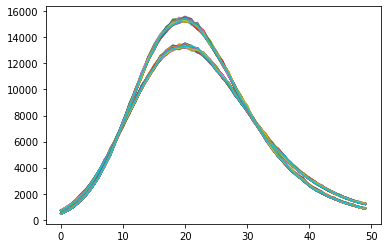

In [50]:
# this is what the data looks like for 2 different cosmologies
plt.plot(data_scaled[40,0:100,:].T)
plt.plot(data_scaled[44,0:100,:].T)
plt.show()

### The data

In [51]:
# We pick a realization at a specific cosmology to be our data (you can change this!)
# right now we choose a cosmology which is fairly close to the fiducial one (see below)
index = 54
data  = data_scaled[index][0]
true_params = cosmo_params[index]
print(true_params)

[0.124  0.3028 2.3174]


### Covariance Matrix

In [52]:
# compute covariance from covariance sims
Cinv = np.linalg.inv(covariance)

In [53]:
# these are the fiducial parameter, i.e. the parameters the covariance was measured at 
fid_params = np.load('/Users/listerchenzhile/Desktop/data/theta.fid.npy',allow_pickle=True)
print(fid_params)

[0.1 0.3 2.1]


In [54]:
#testing fid_params
fid_params_test = [1,1,1]

### Constructing the data likelihood

In [55]:
# average over all simulations for each cosmology
means      = np.mean(data_scaled, axis=1)

In [56]:
#pip install sklearn

#### Forward Model: Gaussian process interpolation of  means

In [57]:
# A Gaussian process is a regression model, it learns to map x-> f(x) from some training data. 
# In our case x are the cosmological parameters and f(x) are the peak counts

import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


kernel = C(1.0, (1e-4, 1e4)) * RBF(1, (1e-4, 1e4))
#Instanciate a Gaussian Process model
gp     = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)


# fit on means and parameters
gp.fit(cosmo_params,means)

#use the GP prediction to build the model
#x=theta, cosmo params --> f(x): peak counts

def fwdmodel(theta): 
    pred, stdev = gp.predict(np.array(theta).reshape(1,3),return_std=True)
    return np.squeeze(pred.T)


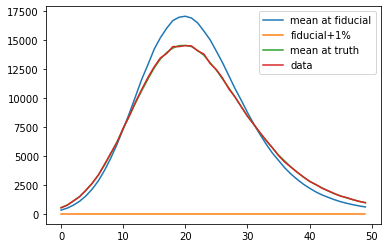

In [58]:
# Check how well the Gaussian process is doing

plt.plot(fwdmodel(fid_params), label='mean at fiducial')
plt.plot(fwdmodel(fid_params*1.01), label= 'fiducial+1%')
plt.plot(fwdmodel(true_params), label='mean at truth')
plt.plot(data, label='data')
plt.legend()
plt.show()

In [59]:
# likelihood
# We assume a Gaussian likelihood for the peak counts. 
# Can you think of reasons why this is a reasonable assumption?
# Hint: Peak counts are a binned statistic (a sum of a random number)

def likelihood(data, params):
    mu  = fwdmodel(params)
    x   = data - mu
    # linalg.slogdet is numerically more stable than np.log(linalg.det())
    _, logdet = np.linalg.slogdet(Cinv)
    x   = np.squeeze(x)
    logp= -0.5*np.dot(np.dot(x, Cinv),x)+0.5*logdet-0.5*len(x)*np.log(2*np.pi)
    return np.squeeze(logp)

In [60]:
# check if output makes sense
-likelihood(data,true_params)

426.4627767277797

In [61]:
#-logpost(data, true_params)

### posterior

    posterior    = prior*likelihood
    logposterior = loglikelihood+logprior

    Task: add a Gaussian prior on the parameters. This prior shouls be centered around the fiducial parameter 
    values, for now let's assume the parameters are uncorrelated, and the sigma is 10% of the parameter value
    construct the posterior

In [62]:
print(fid_params)

[0.1 0.3 2.1]


In [63]:
def logprior(params, mu):
    
    #parameters:
    a, b, c = params
    
    #mean value, fiducial parameters
    a_mu, b_mu, c_mu = mu
    
    #sigma 10% of paramter value:
    sigma_a = 0.1*a
    sigma_b = 0.1*b
    sigma_c = 0.1*c

    #prior is gaussian 
    a_prior = np.log(1.0/(np.sqrt(2*np.pi)*sigma_a))-0.5*(a-a_mu)**2/sigma_a**2
    b_prior = np.log(1.0/(np.sqrt(2*np.pi)*sigma_b))-0.5*(b-b_mu)**2/sigma_b**2
    c_prior = np.log(1.0/(np.sqrt(2*np.pi)*sigma_c))-0.5*(c-c_mu)**2/sigma_c**2
    
    prior_dist = a_prior + b_prior + c_prior
    
    #return np.array([a_prior, b_prior, c_prior])
    return np.array(prior_dist)

In [116]:
logprior(fid_params, fid_params)

array(6.91556023)

In [64]:
def logpost(data, params):
    mu = fid_params
    logpost = logprior(params,mu) + likelihood(data, params)
    return np.squeeze(logpost)

In [65]:
#logpost = logprior(x,fid_params) + likelihood(data, x)
#neglogpost = lambda x: -likelihood(data, x)
neglogpost = lambda x: -logpost(data, x)

### derivatives

In [66]:
pip install numdifftools

Note: you may need to restart the kernel to use updated packages.


In [67]:
import numdifftools as nd

In [68]:
# gradient
grad = nd.Gradient(neglogpost)

In [69]:
# hessian
hess = nd.Hessian(neglogpost)

In [70]:
# derivative by hand
def derivative(params):
    # have to choose delta really small here
    delta_params=1e-5*fid_params
    deriv = np.zeros(len(params))
    for ii in range(len(params)):
        deltas = np.zeros(len(params))
        deltas[ii]+=delta_params[ii]
        deriv[ii] = (neglogpost(params+deltas)-neglogpost(params-deltas))/(2*delta_params[ii])
    return deriv

In [71]:
## numerical differences! (points towards nasty likleihood surface)
with warnings.catch_warnings(record=True):
    print(grad(true_params))
    print(derivative(true_params))

[133.94145883   6.32811104   4.09991083]
[133.94145878   6.32811101   4.09991083]


### find minima

    Q: you can try different minimizers here. Do they all find the same minima?Which ones work and which ones fail?
    A: Tried CG, Nelder-Mead, Powell all work and find same minimas

#### using Melder-mead, if Hessian is defined:

In [72]:
import warnings
from scipy.optimize import minimize

log_posts = [] 
param_ests= []
with warnings.catch_warnings(record=True):
    for theta_ini in 0.15*np.sqrt(fid_params)*np.random.randn(20,3)+fid_params:
        print('theta_ini =',theta_ini) #shape=(10,3)
        for method in ['CG']:#,'Nelder-Mead','Powell','CG','BFGS','Newton-CG','L-BFGS-B','TNC','COBYLA','SLSQP','trust-constr','dogleg','trust-ncg','trust-exact','trust-krylov']:
            res = minimize(neglogpost,theta_ini,jac=grad,hess=hess,method=method)
            #hess = nd.Hessian(neglogpost)
            h = hess(res['x'])
            if res['success']:
                if np.any(np.isnan(h)) == False: #add if hess is pos 
                    if np.linalg.slogdet(h) != '-inf': #if determinant is pos
                            print(res['x'])
                            log_posts.append(neglogpost(res['x']))
                            param_ests.append(res['x']) 
                    
param_ests= np.asarray(param_ests)
param_ests

theta_ini = [0.13650981 0.38224713 1.89205573]
theta_ini = [0.11259127 0.29858673 2.15882889]
theta_ini = [0.09794603 0.2409084  1.97743055]
theta_ini = [0.19463059 0.36246776 2.3289006 ]
theta_ini = [0.11993826 0.27025213 2.04071353]
theta_ini = [0.04936934 0.26312745 1.75631778]
theta_ini = [0.11304937 0.34356988 2.19780579]
theta_ini = [0.09810251 0.40033578 1.95672212]
theta_ini = [0.12438057 0.32456134 2.05019285]
theta_ini = [0.02970517 0.49746606 2.32334423]
theta_ini = [0.05700428 0.31153311 2.5175379 ]
theta_ini = [0.08162417 0.14845984 1.81285992]
theta_ini = [0.0838364  0.36310318 2.07689283]
[0.09901951 0.29705854 2.07940968]
theta_ini = [0.05613488 0.22885344 2.14417034]
theta_ini = [0.19129599 0.41171472 2.05571149]
theta_ini = [0.15928995 0.47412466 2.55272569]
theta_ini = [0.0900042  0.24344794 2.22444122]
[0.09901951 0.29705854 2.07940979]
theta_ini = [0.14559111 0.33097149 2.04510437]
theta_ini = [-0.00812841  0.34553387  2.05336304]
theta_ini = [0.2545767  0.33429462

array([[0.09901951, 0.29705854, 2.07940968],
       [0.09901951, 0.29705854, 2.07940979]])

[1007.7352815293593, 1007.7352815293592]


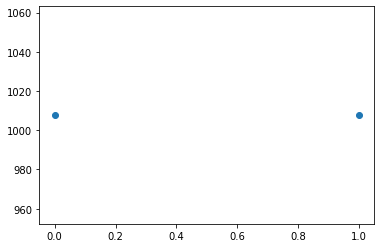

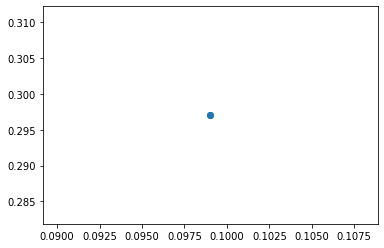

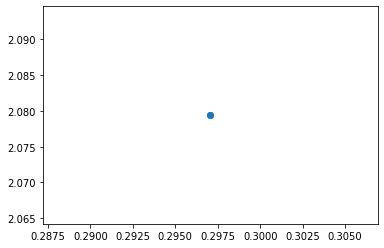

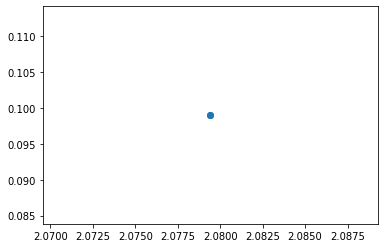

In [73]:
# did they all land in the same minimum?
print(log_posts)
plt.plot(log_posts,ls='', marker='o')
plt.show()

for ii in range(param_ests.shape[-1]):
    if ii==2:
        plt.scatter(param_ests[:,ii],param_ests[:,0])
    else:
        plt.scatter(param_ests[:,ii],param_ests[:,ii+1])
    plt.show()
# parameters are pretty much all over the place

In [74]:
### let's look at the lowest minimum
index       = np.argsort((log_posts))
print(log_posts[index[0]])
best_params = param_ests[index[0]]
print(best_params, true_params, fid_params)

1007.7352815293592
[0.09901951 0.29705854 2.07940979] [0.124  0.3028 2.3174] [0.1 0.3 2.1]


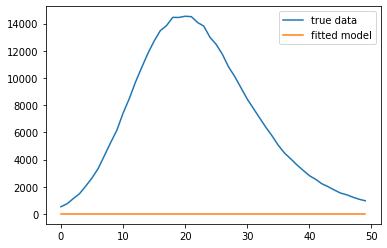

In [75]:
plt.plot(data, label='true data')
plt.plot(fwdmodel(best_params), label = 'fitted model')
plt.legend()

Text(0.5, 1.0, 'ture data vs model with param_ests')

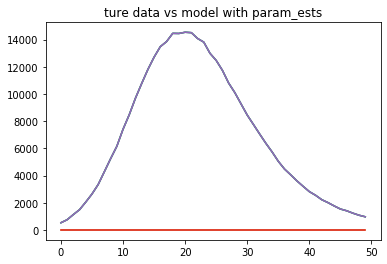

In [76]:
# let's look at all minima:
plt.plot(data)
for ii in range(len(param_ests)):
    plt.plot(fwdmodel(param_ests[ii]))
    plt.plot(data)
plt.title('ture data vs model with param_ests')
## all of them seem to be consistent with the data!

### without if hess is defined statement:

##### method 1: CG

In [77]:
## you can try different minimizers here. Do they all find the same minima? Which ones work and which ones fail?
## what happens is the fiducial parameters are far from the truth?

import warnings
from scipy.optimize import minimize

log_posts = [] 
param_ests= []
with warnings.catch_warnings(record=True):
    for theta_ini in 0.15*np.sqrt(fid_params)*np.random.randn(10,3)+fid_params:
        print('theta_ini =',theta_ini) #shape=(10,3)
        for method in ['CG']:#,'Nelder-Mead','Powell','CG','BFGS','Newton-CG','L-BFGS-B','TNC','COBYLA','SLSQP','trust-constr','dogleg','trust-ncg','trust-exact','trust-krylov']:
            res = minimize(neglogpost,theta_ini,jac=grad,hess=hess,method=method)
            if res['success']:
                print(res['x'])
                log_posts.append(neglogpost(res['x']))
                param_ests.append(res['x'])
param_ests= np.asarray(param_ests)
param_ests

theta_ini = [-0.01642597  0.28248608  1.74777608]
[-0.01642597  0.28248608  1.74777608]
theta_ini = [0.0739426  0.44371425 2.05650721]
[0.09901951 0.29705854 2.07940992]
theta_ini = [0.1839194  0.32543382 2.31817153]
[-1017.33565319  -182.48192989   -27.47721021]
theta_ini = [0.10223173 0.31485019 2.21636893]
[-896.20616713 -509.66241399  -76.56701601]
theta_ini = [0.13811499 0.23755134 2.12684139]
[-771.54672822  688.805703     -3.23794126]
theta_ini = [0.14446015 0.30361718 2.24430743]
[-1032.77068197   -47.66779338   -18.67053286]
theta_ini = [0.07633869 0.40623506 2.31755479]
[0.09901951 0.29705854 2.07940979]
theta_ini = [0.10848595 0.47921876 1.80182396]
[-852.61255901 -573.49132323  116.15659659]
theta_ini = [0.13763631 0.39660129 1.869121  ]
[-983.10546612 -317.23343652   46.55175987]
theta_ini = [0.07723246 0.41055225 1.81868232]
[0.09901951 0.29705854 2.07941014]


array([[-1.64259735e-02,  2.82486080e-01,  1.74777608e+00],
       [ 9.90195138e-02,  2.97058542e-01,  2.07940992e+00],
       [-1.01733565e+03, -1.82481930e+02, -2.74772102e+01],
       [-8.96206167e+02, -5.09662414e+02, -7.65670160e+01],
       [-7.71546728e+02,  6.88805703e+02, -3.23794126e+00],
       [-1.03277068e+03, -4.76677934e+01, -1.86705329e+01],
       [ 9.90195136e-02,  2.97058539e-01,  2.07940979e+00],
       [-8.52612559e+02, -5.73491323e+02,  1.16156597e+02],
       [-9.83105466e+02, -3.17233437e+02,  4.65517599e+01],
       [ 9.90195136e-02,  2.97058541e-01,  2.07941014e+00]])

[nan, 1007.7352815293594, nan, nan, nan, nan, 1007.7352815293592, nan, nan, 1007.7352815293607]


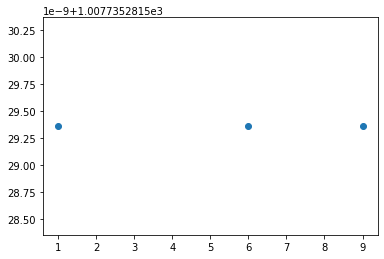

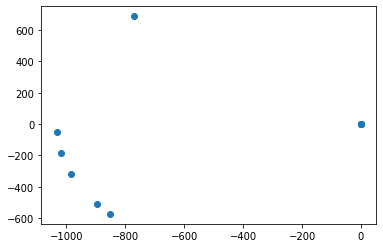

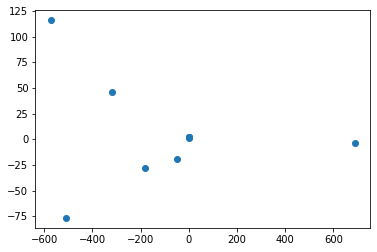

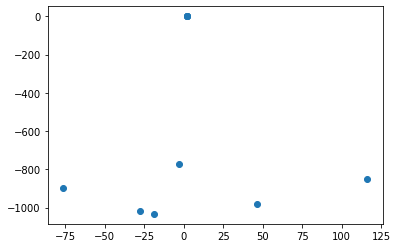

In [78]:
# did they all land in the same minimum?
print(log_posts)
plt.plot(log_posts,ls='', marker='o')
plt.show()

for ii in range(param_ests.shape[-1]):
    if ii==2:
        plt.scatter(param_ests[:,ii],param_ests[:,0])
    else:
        plt.scatter(param_ests[:,ii],param_ests[:,ii+1])
    plt.show()
# parameters are pretty much all over the place

In [79]:
### let's look at the lowest minimum
index       = np.argsort((log_posts))
print(log_posts[index[0]])
best_params = param_ests[index[0]]
print(best_params, true_params, fid_params)

1007.7352815293592
[0.09901951 0.29705854 2.07940979] [0.124  0.3028 2.3174] [0.1 0.3 2.1]


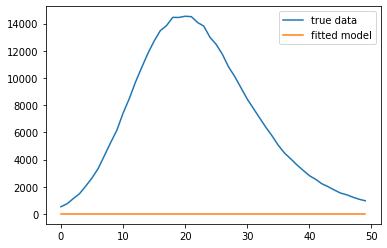

In [80]:
plt.plot(data, label='true data')
plt.plot(fwdmodel(best_params), label = 'fitted model')
plt.legend()

No handles with labels found to put in legend.


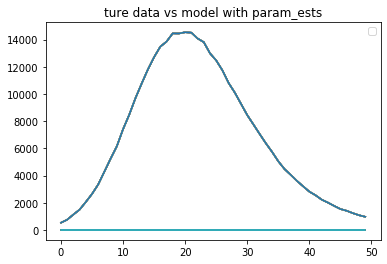

In [81]:
# let's look at all minima:
plt.plot(data)
for ii in range(len(param_ests)):
    plt.plot(fwdmodel(param_ests[ii]))
    plt.plot(data)
plt.title('ture data vs model with param_ests')
plt.legend()

## all of them seem to be consistent with the data!

##### method 2 = 'Nelder_mead'

    fastest!

In [82]:
import warnings
from scipy.optimize import minimize

log_posts2 = [] 
param_ests2= []
with warnings.catch_warnings(record=True):
    for theta_ini in 0.15*np.sqrt(fid_params)*np.random.randn(10,3)+fid_params:
        print('theta_ini =',theta_ini)
        for method in ['Nelder-Mead']:#,'Nelder-Mead','Powell','CG','BFGS','Newton-CG','L-BFGS-B','TNC','COBYLA','SLSQP','trust-constr','dogleg','trust-ncg','trust-exact','trust-krylov']:
            res = minimize(neglogpost,theta_ini,jac=grad,hess=hess,method=method)
            if res['success']:
                log_posts2.append(neglogpost(res['x']))
                param_ests2.append(res['x'])
param_ests2= np.asarray(param_ests2)
param_ests2

theta_ini = [0.09860043 0.22069849 2.437426  ]
theta_ini = [0.13471536 0.18344863 1.92805998]
theta_ini = [0.0537257  0.27476135 2.1652926 ]
theta_ini = [0.11526455 0.33021684 2.01021831]
theta_ini = [0.08124798 0.20997067 1.71619557]
theta_ini = [0.10572275 0.30710786 1.92428577]
theta_ini = [0.13542788 0.26321627 2.07278412]
theta_ini = [0.15473554 0.23642293 1.94916365]
theta_ini = [0.11031917 0.13156273 1.90000811]
theta_ini = [0.08360361 0.42778174 2.14957962]


array([[0.09902103, 0.29705804, 2.07941647],
       [0.09902125, 0.29704382, 2.07938515],
       [0.09901869, 0.29705727, 2.0794574 ],
       [0.09902029, 0.29706008, 2.07936584],
       [0.09902028, 0.297059  , 2.07938289],
       [0.099023  , 0.29706607, 2.07941545],
       [0.09902276, 0.2970567 , 2.07940804],
       [0.09901786, 0.29706681, 2.07945843],
       [0.09902137, 0.29705536, 2.07941277],
       [0.09901891, 0.29704665, 2.07938091]])

[1007.7352815421281, 1007.7352816789227, 1007.7352815608429, 1007.7352815568917, 1007.7352815412052, 1007.7352816264676, 1007.7352815866426, 1007.7352816118305, 1007.7352815535637, 1007.7352816237011]


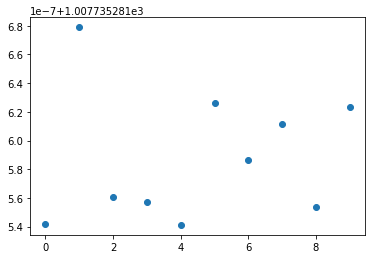

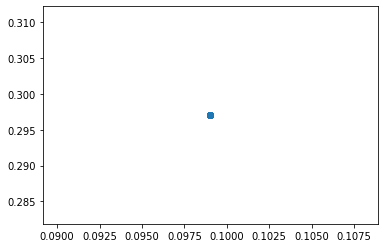

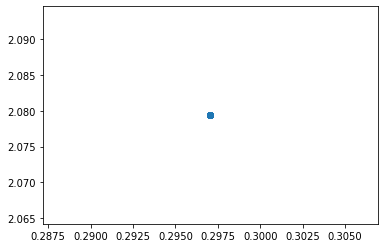

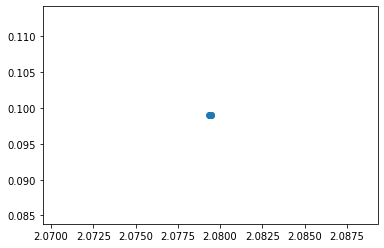

In [83]:
# did they all land in the same minimum?
print(log_posts2)
plt.plot(log_posts2,ls='', marker='o')
plt.show()

for ii in range(param_ests2.shape[-1]):
    if ii==2:
        plt.scatter(param_ests2[:,ii],param_ests2[:,0])
    else:
        plt.scatter(param_ests2[:,ii],param_ests2[:,ii+1])
    plt.show()
# parameters are pretty much all over the place

In [84]:
### let's look at the lowest minimum
index       = np.argsort((log_posts2))
print(log_posts2[index[0]])
best_params2 = param_ests2[index[0]]
print(best_params2, true_params, fid_params)

1007.7352815412052
[0.09902028 0.297059   2.07938289] [0.124  0.3028 2.3174] [0.1 0.3 2.1]


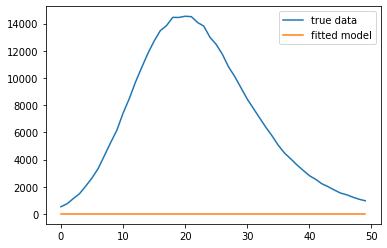

In [85]:
plt.plot(data, label='true data')
plt.plot(fwdmodel(best_params2), label = 'fitted model')
plt.legend()

No handles with labels found to put in legend.


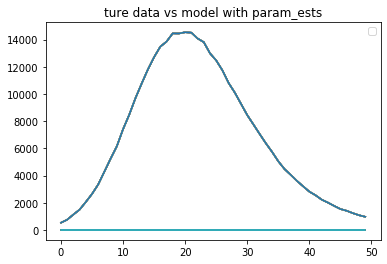

In [86]:
# let's look at all minima:
plt.plot(data)
for ii in range(len(param_ests2)):
    plt.plot(fwdmodel(param_ests2[ii]))
    plt.plot(data)
plt.title('ture data vs model with param_ests')
plt.legend()
## all of them seem to be consistent with the data!

##### method 3 ='Powell'

In [87]:
import warnings
from scipy.optimize import minimize

log_posts3 = [] 
param_ests3= []
with warnings.catch_warnings(record=True):
    for theta_ini in 0.15*np.sqrt(fid_params)*np.random.randn(10,3)+fid_params:
        print('theta_ini =',theta_ini)
        for method in ['Powell']:#,'Nelder-Mead','Powell','CG','BFGS','Newton-CG','L-BFGS-B','TNC','COBYLA','SLSQP','trust-constr','dogleg','trust-ncg','trust-exact','trust-krylov']:
            res = minimize(neglogpost,theta_ini,jac=grad,hess=hess,method=method)
            if res['success']:
                log_posts3.append(neglogpost(res['x']))
                param_ests3.append(res['x'])
param_ests3= np.asarray(param_ests3)
param_ests3

theta_ini = [0.17985462 0.40262303 1.91237707]
theta_ini = [0.09202434 0.33256837 2.21890167]
theta_ini = [0.10941496 0.22372409 1.95485868]
theta_ini = [0.10729055 0.24589346 2.07759824]
theta_ini = [0.07519793 0.20604173 2.0260709 ]
theta_ini = [0.02875137 0.3590221  2.00277584]
theta_ini = [0.08980848 0.26035004 2.17081188]
theta_ini = [0.13217986 0.41946322 2.1336605 ]
theta_ini = [0.0863988  0.20326248 1.75636163]
theta_ini = [0.05102694 0.26043863 1.77586467]


array([], dtype=float64)

[]


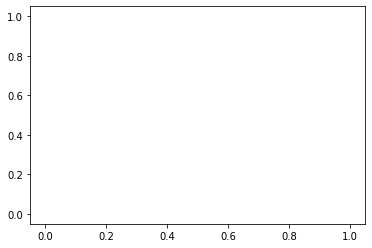

In [88]:
# did they all land in the same minimum?
print(log_posts3)
plt.plot(log_posts3,ls='', marker='o')
plt.show()

for ii in range(param_ests3.shape[-1]):
    if ii==2:
        plt.scatter(param_ests3[:,ii],param_ests3[:,0])
    else:
        plt.scatter(param_ests3[:,ii],param_ests3[:,ii+1])
    plt.show()
# parameters are pretty much all over the place

In [89]:
### let's look at the lowest minimum
index       = np.argsort((log_posts3))
print(log_posts3[index[0]])
best_params3 = param_ests3[index[0]]
print(best_params3, true_params, fid_params)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
plt.plot(data, label='true data')
plt.plot(fwdmodel(best_params3),label='fitted model')
plt.legend()

In [ ]:
# let's look at all minima:
plt.plot(data)
for ii in range(len(param_ests3)):
    plt.plot(fwdmodel(param_ests3[ii]))
    plt.plot(data)
plt.title('ture data vs model with param_ests')
plt.legend()
## all of them seem to be consistent with the data!

    Q:what do we learn from this about the posterior?
    A:We use gaussian prior bc most of the time we can fit a gaussian distribution to a distribution. Easy to quantify given gaussian distribution characteristics. The differet posterior can give us a slightly different results given it's closeness to true parameters. 

### With fid_params far from true params:

    Q: what happens is the fiducial parameters are far from the truth?
    A: the estimates is off and fwdmodel does not match up with real data

In [90]:
print(fid_params_test)

[1, 1, 1]


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

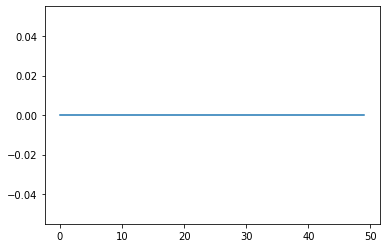

In [91]:
fwdmodel([1,1,1])
plt.plot(fwdmodel([1,1,1]))
plt.plot

In [92]:
fwdmodel(fid_params)

array([  329.98024535,   499.10792783,   760.99576048,  1099.25112543,
        1553.27935411,  2135.29609925,  2852.31550986,  3759.74148191,
        4812.33669493,  6006.55466909,  7321.35295741,  8696.6778348 ,
       10171.6982007 , 11642.62041213, 12910.68397738, 14236.90981181,
       15226.1412519 , 16039.86134583, 16707.3088495 , 16992.76107034,
       17079.21636749, 16924.43222565, 16497.75129698, 15796.33639762,
       15045.11315934, 14065.33899879, 13062.47331403, 11953.92253038,
       10843.71672282,  9834.07332105,  8773.67585241,  7797.2117397 ,
        6894.35678609,  6050.13696565,  5276.05863514,  4632.80600496,
        3989.0805108 ,  3449.14865962,  2995.12043094,  2574.35030199,
        2226.87408948,  1907.29685163,  1643.35994174,  1434.03882121,
        1228.73704449,  1057.0874208 ,   917.04087292,   795.98769478,
         690.14497458,   601.32535754])

In [93]:
## you can try different minimizers here. Do they all find the same minima? Which ones work and which ones fail?
## what happens is the fiducial parameters are far from the truth?

import warnings
from scipy.optimize import minimize

log_posts4 = [] 
param_ests4= []
with warnings.catch_warnings(record=True):
    for theta_ini in 0.15*np.sqrt(fid_params_test)*np.random.randn(10,3)+fid_params_test:
        print('theta_ini =',theta_ini) #shape=(10,3)
        for method in ['CG']:#,'Nelder-Mead','Powell','CG','BFGS','Newton-CG','L-BFGS-B','TNC','COBYLA','SLSQP','trust-constr','dogleg','trust-ncg','trust-exact','trust-krylov']:
            res = minimize(neglogpost,theta_ini,jac=grad,hess=hess,method=method)
            if res['success']:
                log_posts4.append(neglogpost(res['x']))
                param_ests4.append(res['x'])
param_ests4= np.asarray(param_ests4)
param_ests4

theta_ini = [1.03960469 0.91978878 0.99212048]
theta_ini = [1.21636072 0.89824913 1.0294357 ]
theta_ini = [0.76890325 0.87458946 0.99238434]
theta_ini = [1.06494491 1.00115613 0.76989421]
theta_ini = [1.26997712 1.18774663 0.83202832]
theta_ini = [0.80553715 1.02743372 0.96688417]
theta_ini = [1.06763221 1.01059779 1.01747014]
theta_ini = [0.87469028 0.99211135 0.8858384 ]
theta_ini = [1.11931048 0.77519086 0.86260152]
theta_ini = [1.00327717 0.61368212 1.1765615 ]


array([[-1346.87628537, -4018.77867984,   305.55457453],
       [ -805.74900311, -3498.27834784,   137.24520305],
       [-1799.29538031, -3119.90265914,   223.00002857],
       [-3709.38439332, -9417.73864824,  4622.90208444],
       [-3751.49595691, -9961.52035836,  4619.2491875 ],
       [-2832.57264211, -4039.38968885,   507.92428257],
       [-1564.92503041, -4166.46003882,   248.05811053],
       [-3244.71923482, -5819.21182013,  1392.77889032],
       [-1240.59713362, -5400.01775536,  1015.02266531],
       [-1169.09502588,  2358.95420961,  1713.01105534]])

[nan, 1007.7352815293594, nan, nan, nan, nan, 1007.7352815293592, nan, nan, 1007.7352815293607]


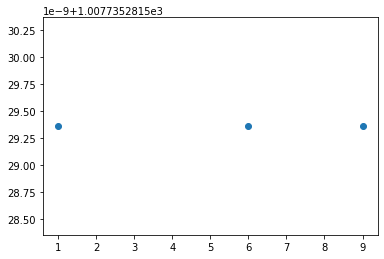

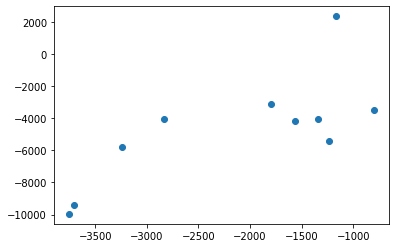

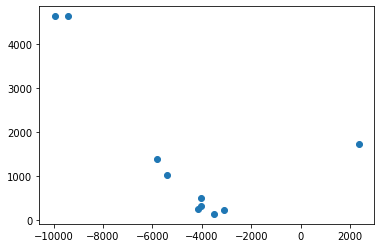

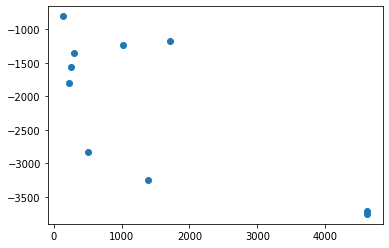

In [94]:
# did they all land in the same minimum?
print(log_posts)
plt.plot(log_posts,ls='', marker='o')
plt.show()

for ii in range(param_ests.shape[-1]):
    if ii==2:
        plt.scatter(param_ests4[:,ii],param_ests4[:,0])
    else:
        plt.scatter(param_ests4[:,ii],param_ests4[:,ii+1])
    plt.show()
# parameters are pretty much all over the place

In [95]:
### let's look at the lowest minimum
index       = np.argsort((log_posts4))
print(log_posts4[index[0]])
best_params4 = param_ests4[index[0]]
print(best_params4, true_params, fid_params)

nan
[-1346.87628537 -4018.77867984   305.55457453] [0.124  0.3028 2.3174] [0.1 0.3 2.1]


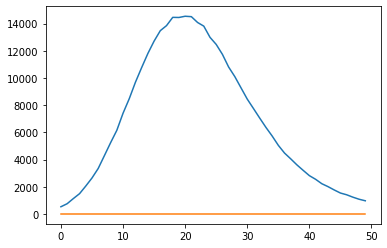

In [96]:
plt.plot(data)
plt.plot(fwdmodel(best_params4))

Text(0.5, 1.0, 'ture data vs model with param_ests')

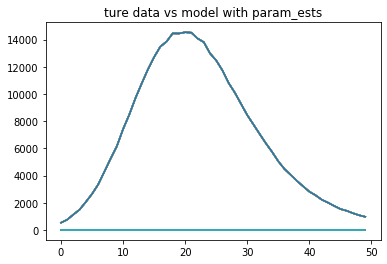

In [97]:
# let's look at all minima:
plt.plot(data)
for ii in range(len(param_ests4)):
    plt.plot(fwdmodel(param_ests4[ii]))
    plt.plot(data)
plt.title('ture data vs model with param_ests')
## all of them seem to be consistent with the data!

# Fisher Analysis

first define the Gaussian function

In [98]:
def get_Gaussian_1d(mu,Sigma):
    if np.isscalar(Sigma):
        Sigma = np.asarray([Sigma])
        mu    = np.asarray([mu])
    Sigma = Sigma[np.newaxis,:]
    mu = mu[np.newaxis, :] 
    def Gaussian(x):
        if len(mu.shape)<3:
            x = x[:,np.newaxis]
        else: 
            x = x[:,np.newaxis, np.newaxis]
        return np.prod(1/np.sqrt((2.*np.pi))/Sigma*np.exp(-0.5*(x-mu)**2/Sigma**2),axis=0)    
    return Gaussian

# 1,100,100 + 20, 1, 1 -> 20, 100, 100
# broadcasting rules

#this function returns an Nd Gaussian
def get_Gaussian_nd(mu,C):
    Cinv = np.linalg.inv(C)
    N    = mu.shape[-1]
    def Gaussian(x):
        x_ = x-mu
        return 1./np.sqrt(np.linalg.det(C))/np.sqrt((2*np.pi)**N)*np.exp(-0.5*np.einsum('ij,jk,ik->i',x_,Cinv,x_))
    return Gaussian

In [99]:
def data_probability(params, data):
    #parameters:
    a, b, c = params
    
    #mean value, fiducial parameters
    
    fid_params = np.array([0.1,0.3, 2.1])
    mu = fid_params
    a_mu, b_mu, c_mu = mu
    
    #sigma 10% of paramter value:
    sigma_a = 0.1*a
    sigma_b = 0.1*b
    sigma_c = 0.1*c
    
    prob_a = get_Gaussian_1d(a_mu, sigma_a)
    prob_b = get_Gaussian_1d(b_mu, sigma_b)
    prob_c = get_Gaussian_1d(c_mu, sigma_c)
    
    prob = prob_a(data)*prob_b(data)*prob_c(data)
    
    return prob

In [100]:
#prob_a = get_Gaussian_1d(0.1, 0.1*a)
#prob_a(data)

In [101]:
#finite differencing
#compeare the python package
def finite_diff(params,func,h=1e-2):
    result = np.zeros(len(params))
    for ii in range(len(params)):
        delta_params     = np.zeros_like(params)
        delta_params[ii] = h
        derivative       = (func(params+delta_params)-func(params-delta_params))/(2*h)
        result[ii]       = derivative 
    return result
#try lambda tool for the derivative

In [102]:
from functools import partial

In [103]:
true_params

array([0.124 , 0.3028, 2.3174])

In [115]:
p_of_params = partial(data_probability, data=data)
deriv       = partial(finite_diff,func=p_of_params, h=1e-3)
p_of_params_log = lambda x: -np.log(partial(data_probability, data=data)(x))
print(p_of_params(fid_params))

[0.]


In [105]:
from scipy.optimize import fsolve, minimize

In [106]:
params_init = [0.1, 0.3, 2.0]
a, b, c = params_init
result = minimize(lambda params: -p_of_params(params),params_init, jac=lambda params: -deriv(params), method='L-BFGS-B', options=dict(gtol=1e-40,ftol=1e-40))
print(result)


      fun: array([-0.])
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0., -0., -0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 1
      nit: 0
   status: 0
  success: True
        x: array([0.1, 0.3, 2. ])


In [107]:
from mpl_toolkits import mplot3d

In [108]:
# this solver tries to minimize the derivative, to find the maximum
output= fsolve(lambda x: -deriv(x),params_init,full_output=True,maxfev=1000,xtol=1e-10)
print(output)
best_params= output[0]
print(best_params)
print(deriv(best_params))

(array([0.1, 0.3, 2. ]), {'nfev': 5, 'fjac': array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), 'r': array([-0.,  0.,  0., -0.,  0., -0.]), 'qtf': array([-0., -0., -0.]), 'fvec': array([-0., -0., -0.])}, 1, 'The solution converged.')
[0.1 0.3 2. ]
[0. 0. 0.]


In [109]:
result = minimize(lambda params: -p_of_params(params),params_init, method='Nelder-Mead')
print(result)
best_params=result['x']

print(best_params)
print(deriv(best_params))

 final_simplex: (array([[0.1       , 0.3       , 2.        ],
       [0.10000488, 0.3       , 2.        ],
       [0.1       , 0.30001465, 2.        ],
       [0.1       , 0.3       , 2.00009766]]), array([-0., -0., -0., -0.]))
           fun: -0.0
       message: 'Optimization terminated successfully.'
          nfev: 54
           nit: 11
        status: 0
       success: True
             x: array([0.1, 0.3, 2. ])
[0.1 0.3 2. ]
[0. 0. 0.]


In [110]:
result = minimize(lambda params: -p_of_params(params),params_init, method='L-BFGS-B')
print(result)
best_params=result['x']

print(best_params)
print(deriv(best_params))

      fun: array([-0.])
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 0
   status: 0
  success: True
        x: array([0.1, 0.3, 2. ])
[0.1 0.3 2. ]
[0. 0. 0.]


In [111]:
a_max = best_params[0]
b_max = best_params[1]
c_max = best_params[2]
a = true_params[0]
b = true_params[1]
c = true_params[2]
X_matrix = np.vstack((a,b,c)).T
mu_matrix = np.vstack((a_max, b_max,c_max)).T


def max_likelihood(mu_matrix, F):
    N = mu_matrix.shape[-1]
    detF = np.linalg.det(F) #determinant of fisher matrix 
    inv_F = np.linalg.inv(F)
    def get_distribution(x_matrix):
        x_mu = (x_matrix-mu_matrix)
        g_distribution = 1/((2*np.pi)**(N/2)*np.sqrt(np.linalg.det(F)))*np.exp(-0.5*np.einsum("ij,jk,ik->i",x_mu, inv_F, x_mu))
        return g_distribution
    return get_distribution

In [112]:
import numdifftools as nd

In [113]:
F           = nd.Hessian(p_of_params_log)(best_params)
Hessian = F
C           = np.linalg.inv(Hessian) #inverse of F
print('F=',F,'\n','C=',C)

F= [[nan nan nan]
 [nan nan nan]
 [nan nan nan]] 
 C= [[nan nan nan]
 [nan nan nan]
 [nan nan nan]]


/Users/listerchenzhile/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/listerchenzhile/miniconda3/lib/python3.7/site-packages/numdifftools/core.py:894: RuntimeWarning: invalid value encountered in subtract
  hess[i, i] = (f(x + 2 * ee[i, :]) - 2 * fx + f(x - 2 * ee[i, :])) / (4. * hess[i, i])
/Users/listerchenzhile/miniconda3/lib/python3.7/site-packages/numdifftools/core.py:899: RuntimeWarning: invalid value encountered in subtract
  + f(x - ee[i, :] - ee[j, :])) / (4. * hess[j, i])
/Users/listerchenzhile/miniconda3/lib/python3.7/site-packages/numdifftools/extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/listerchenzhile/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/l

In [ ]:
a_max_high = best_params[0]
b_max_high = best_params[1]
a = true_params[0]
b = true_params[1]
X_matrix = np.vstack((a,b)).T
mu_matrix = np.vstack((a_max_high,b_max_high)).T
def max_likelihood(mu_matrix, F):
    N = mu_matrix.shape[-1]
    detF = np.linalg.det(F) #determinant of fisher matrix 
    inv_F = np.linalg.inv(F)
    def get_distribution(x_matrix):
        x_mu = (x_matrix-mu_matrix)
        g_distribution = 1/((2*np.pi)**(N/2)*np.sqrt(np.linalg.det(F)))*np.exp(-0.5*np.einsum("ij,jk,ik->i",x_mu, inv_F, x_mu))
        return g_distribution
    return get_distribution

In [ ]:
F           = nd.Hessian(p_of_params_log)(best_params)
Hessian = F
C           = np.linalg.inv(Hessian) #inverse of F
print('F=',F,'\n','C=',C)

In [ ]:
approx_posterior = get_Gaussian_nd(best_params,C)
print(best_params)